<a href="https://colab.research.google.com/github/Mohitnayak/BERT/blob/master/BERT_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 30.0 MB/s 
     |████████████████████████████████| 3.3 MB 43.6 MB/s 
     |████████████████████████████████| 636 kB 43.1 MB/s 
     |████████████████████████████████| 895 kB 28.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 6
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 4.25MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 33.5MB/s]


In [5]:
df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [6]:
df.shape

(15746, 11)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


Text(0.5, 0, 'review score')

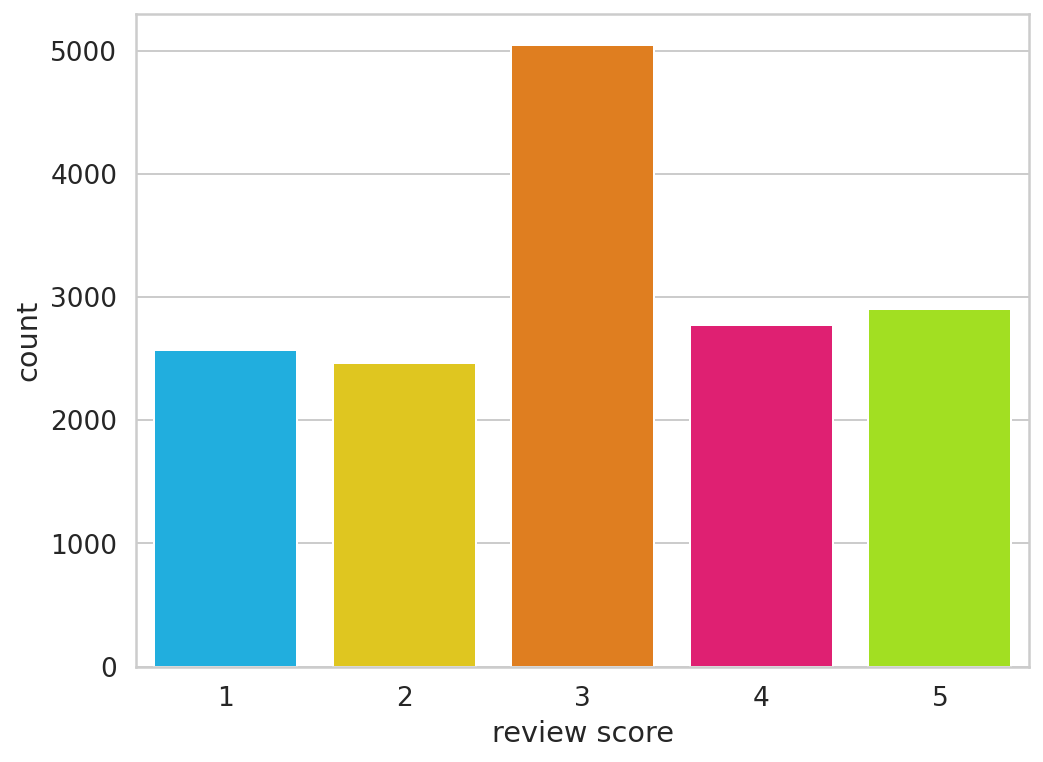

In [8]:
sns.countplot(df.score)
plt.xlabel("review score")


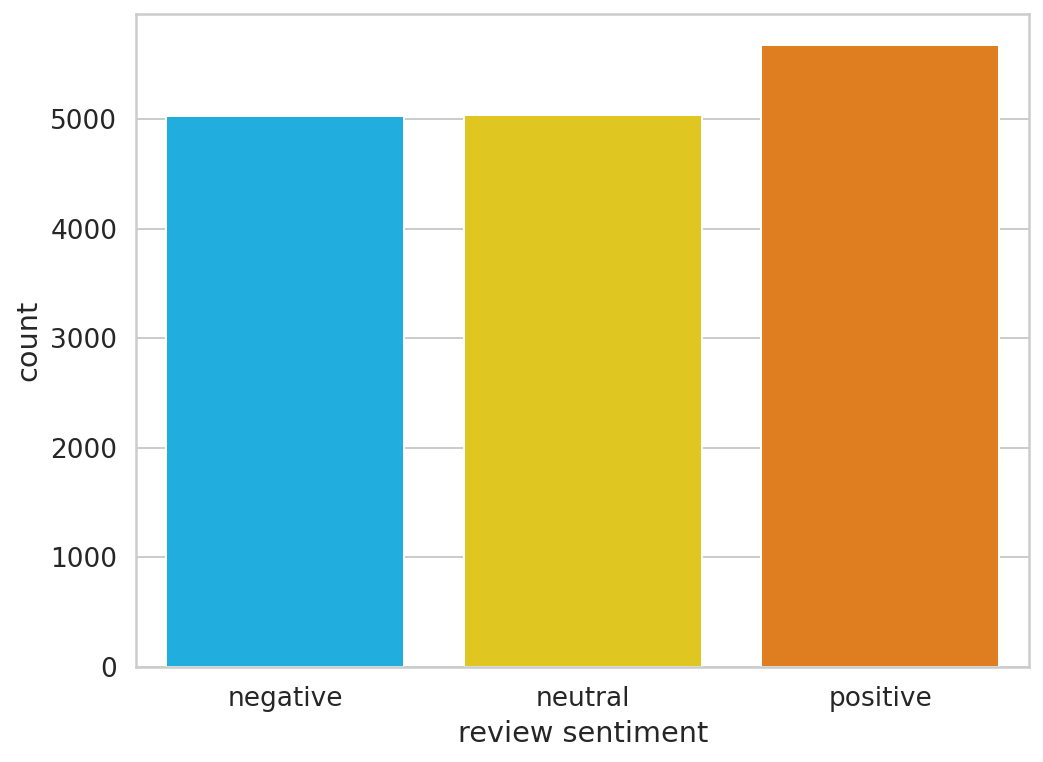

In [9]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2
df['sentiment'] = df.score.apply(to_sentiment)

class_names = ['negative', 'neutral', 'positive']

ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

### Data Preprocessing


In [10]:
PRE_TRAINED_MODEL = "bert-base-cased"
tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)

In [11]:
sample_txt = "When was i last out? Im stuck at home for 2 weeks"

In [12]:
tokens = tokenizer.tokenize(sample_txt)
tokens

['When',
 'was',
 'i',
 'last',
 'out',
 '?',
 'I',
 '##m',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks']

In [13]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)
token_ids

[1332,
 1108,
 178,
 1314,
 1149,
 136,
 146,
 1306,
 5342,
 1120,
 1313,
 1111,
 123,
 2277]

In [14]:
print(f'sentence : {sample_txt}')
print(f'tokens : {tokens}')
print(f'token_ids : {token_ids}')

sentence : When was i last out? Im stuck at home for 2 weeks
tokens : ['When', 'was', 'i', 'last', 'out', '?', 'I', '##m', 'stuck', 'at', 'home', 'for', '2', 'weeks']
token_ids : [1332, 1108, 178, 1314, 1149, 136, 146, 1306, 5342, 1120, 1313, 1111, 123, 2277]


### Special Tokens

In [15]:
tokenizer.sep_token,tokenizer.sep_token_id

('[SEP]', 102)

In [16]:
tokenizer.cls_token,tokenizer.cls_token_id

('[CLS]', 101)

In [17]:
tokenizer.pad_token,tokenizer.pad_token_id

('[PAD]', 0)

In [18]:
tokenizer.unk_token,tokenizer.unk_token_id

('[UNK]', 100)

In [20]:
encoding = tokenizer.encode_plus(sample_txt,
                      max_length=32,
                      add_special_tokens=True,
                      pad_to_max_length = True,
                      return_attention_mask = True,
                      return_token_type_ids = False,
                      return_tensors = "pt",
                      truncation = True
                      )

In [21]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

### Choosing Sequence lengths

In [22]:
token_lens = []
for txt in df.content:
  token = tokenizer.encode(txt,max_length=512)
  token_lens.append(len(token))

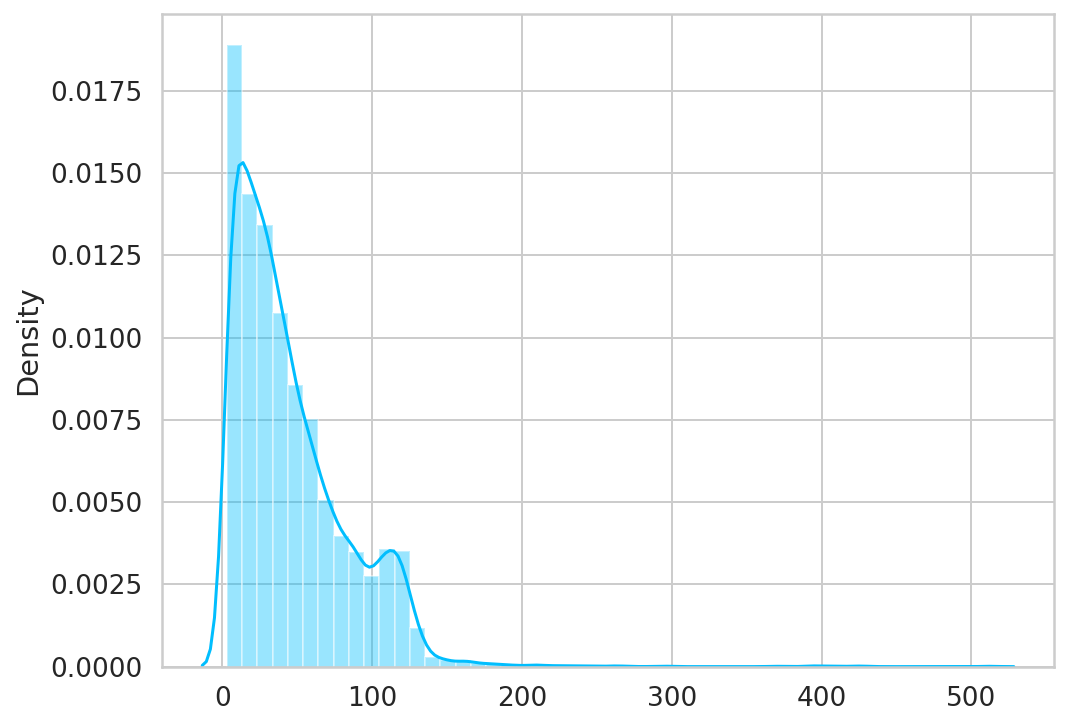

In [23]:
sns.distplot(token_lens)

### Create a dataset

In [37]:
class GPReviewDataset(Dataset):

  def __init__(self,reviews,targets,tokenizer,max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self,item):
    review = str(self.reviews["item"])
    target = self.targets["item"]

    encoding = tokenizer.encode_plus(
        review,
        max_length=self.max_len,
        add_special_tokens=True,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_token_type_ids = False,
        return_tensors = "pt"
    )
    return {
        'review_text':review,
        'input_ids': encoding["input_ids"],
        'attention_mask': encoding["attention_mask"],
        'targets' : torch.tensor(self.target(item),dtype=torch.long)

    }


In [38]:
MAX_LEN = 160
BATCH_SIZE = 16
EPOCHS = 50

In [39]:
df_train, df_test = train_test_split(df,test_size = 0.1,random_state = RANDOM_SEED)
df_val, df_test = train_test_split(df_test,test_size = 0.5,random_state = RANDOM_SEED)


In [33]:
df_train.shape,df_test.shape,df_val.shape

((14171, 12), (788, 12), (787, 12))

In [44]:
def create_data_loader(df,tokenizer,max_len,batch_size):
  ds = GPReviewDataset(
      reviews = df.content.to_numpy(),
      targets = df.sentiment.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )
  return DataLoader(
      ds,
      batch_size = batch_size,
      num_workers = 4 
      )

In [45]:
train_data_loader = create_data_loader(df_train,tokenizer,MAX_LEN,BATCH_SIZE)
test_data_loader = create_data_loader(df_test,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(df_val,tokenizer,MAX_LEN,BATCH_SIZE)

In [49]:
next(iter(test_data_loader)).keys()
# data.keys()

IndexError: ignored

In [ ]:
#dd